# Introduction 

In this tutorial, we will make use of the next-generation Pose Detection model from Google Research which can detect up to 17 keypoints in the human body. 

# MoveNet architecture in a nutshell 

## How does it work ? 

MoveNet uses heatmaps to accurately localize human keypoints. It's a **bottom-up** estimation model, which means that it first detects the human joints of all persons, and then assemble these joints into poses for each person.[[Source]](https://arxiv.org/pdf/1807.09972.pdf#:~:text=The%20top%2Ddown%20approaches%20first,full%20poses%20for%20all%20persons.)

## Architecture (2 main components)

- **Feature extractor** : A MobileNetV2 with an attached feature pyramid network
- **A set of predictor heads** : attached to the feature extractor. They are responsible for predicting : 
 - the geometric center of the instances (persons)
 - the full set of keypoints for a person
 - the location of all the keypoints
 - local offsets from each output feature map pixel to the precise sub-pixel location of each keypoint
 
 
## [A deeper explanation on the MoveNet processing steps](https://blog.tensorflow.org/2021/05/next-generation-pose-detection-with-movenet-and-tensorflowjs.html). Now, let's start coding ! 





# Libraries

In [1]:
#Calculations and Deep Learning library
import tensorflow as tf 
import tensorflow_hub as hub
import numpy as np 

#Computer vision/graphics library
import cv2

#Gif writer
import imageio 

#Display libraries 
import matplotlib.pyplot as plt 
from IPython.display import HTML, display

In [2]:
! pip install -q git+https://github.com/tensorflow/docs

> We will use the "embed" module from TF Docs to embed the fig to our Notebook

# Setup

## Map the joint names to keypoint indices 

In [3]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

## Map the bones (keypoint edges) to a matplotlib color name

 Reference : [Matplotlib colors](https://matplotlib.org/stable/gallery/color/named_colors.html)

> ![Colors_index](https://raw.githubusercontent.com/Justsecret123/Human-pose-estimation/main/Screenshots/mpl_colors.PNG)

In [4]:
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Load the model from TF hub

> *Notes* : MoveNet is offered with two variants, known as : 
> - Lightning : intended for latency-critical applications 
> - Thunder : for applications applications that require high accuracy 

We will load the multipose *Lightning* model, which is able to detect mutliple people (up to 6 instances) in the image frame at the same time. 

In [5]:
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures['serving_default']

2022-02-17 16:59:49.212125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:59:49.332739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:59:49.333843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:59:49.335497: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Adjust the input size 

According to [the official documentation](https://tfhub.dev/google/movenet/multipose/lightning/1) : 

1. The height/width are both multiple of 32.
2. The height to width ratio is close (and enough) to cover the original image's aspect ratio.
3. Make the larger side to be 256 (one should adjust this based on the speed/accuracy requirements). For example, a 720p image (i.e. 720x1280 (HxW)) should be resized and padded to 160x256 image.

In [6]:
input_size = 256

# Inference

## Download the test gif

In [7]:
! wget -O ngannou.gif https://raw.githubusercontent.com/Justsecret123/Human-pose-estimation/main/Test%20gifs/Ngannou_jairzinho.gif

--2022-02-17 17:00:09--  https://raw.githubusercontent.com/Justsecret123/Human-pose-estimation/main/Test%20gifs/Ngannou_jairzinho.gif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4306456 (4.1M) [image/gif]
Saving to: ‘ngannou.gif’

ngannou.gif         100%[===================>]   4.11M  --.-KB/s    in 0.04s   

2022-02-17 17:00:09 (113 MB/s) - ‘ngannou.gif’ saved [4306456/4306456]



## Define the loop

In [8]:
def loop(frame, keypoints, threshold=0.11):
    #Loop through the results
    for instance in keypoints: 
        (denormalized_coordinates, width, height) = draw_keypoints(frame, instance,threshold)
        draw_edges(denormalized_coordinates, width, height, frame, instance, KEYPOINT_EDGE_INDS_TO_COLOR,threshold)

## Draw keypoints

### Steps : 
- Get the parameters (shape): width, height, channel 
- Denormalize the output coordinates by mutliplying the keypoints with the with the parameters
- Iterate through the denormalized keypoints and draw the circles where the confidence score is higher than the preset threshold

In [9]:
def draw_keypoints(frame, keypoints,threshold=0.11):
    #Get the parameters
    width, height, _ = frame.shape
    #Denormalize the coordinates 
    denormalized_coordinates = np.squeeze(np.multiply(keypoints, [width,height,1]))
    #Iterate
    for keypoint in denormalized_coordinates:
        #Unpack the keypoint values : y, x, confidence score
        keypoint_y, keypoint_x, keypoint_confidence = keypoint
        if keypoint_confidence > threshold:
            #Draw the circle
            cv2.circle(frame, (int(keypoint_x), int(keypoint_y)), 4, (255,0,0), -1)
    return denormalized_coordinates, width, height

## Draw the edges 
### Steps : 
- Iterate through the edges and draw the edges
- Get the edge points and the associated dict value
- Draw the lines where the confidence score is higher than the preset threshold

In [10]:
def draw_edges(denormalized_coordinates, width, height, frame, keypoints, edges, threshold=0.11):
    
    #Iterate
    for edge, color in edges.items():
        #Get the dict value associated to the actual edge
        p1, p2 = edge
        #Get the points
        y1, x1, confidence_1 = denormalized_coordinates[p1]
        y2, x2, confidence_2 = denormalized_coordinates[p2]
        #Draw the line if the confidence > threshold
        if (confidence_1 > threshold) & (confidence_2 > threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 4)

## Progress bar

In [11]:
def progress(value, max=100):
    #Return an HTML progress bar 
    return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value,
                max=max))

## Capture and process each frame

### Load the gif

In [12]:
gif = cv2.VideoCapture("./ngannou.gif")
frame_count = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Frame count: {frame_count}")

Frame count: 103


### Configure the video writer

In [13]:
output_frames = []

## Run inference

In [14]:
def run_inference():
    
    #Set the progress bar to 0. It ranges from the first to the last frame
    bar = display(progress(0, frame_count-1), display_id=True)
    
    while gif.isOpened():
        
        #Capture the frame
        ret, frame = gif.read()
        
        #Process the frame : resize to the input size
        if frame is None: 
            break
        
        #Retrieve the frame index
        index = gif.get(cv2.CAP_PROP_POS_FRAMES)
        
        image = frame.copy()
        image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
        input_image = tf.expand_dims(image, axis=0)

        #Perform inference
        results = movenet(input_image)
        keypoints = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

        #Loop through the results
        loop(frame, keypoints, threshold=0.11)
        
        #Add the drawings to the output frames
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #OpenCV processes BGR images instead of RGB
        output_frames.append(frame_rgb)
        
        #Update the progress bar
        bar.update(progress(index, frame_count-1))
    
    #Release the object
    gif.release()

In [15]:
run_inference()

2022-02-17 17:00:11.077868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-17 17:00:12.637277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


## Display the results

In [16]:
from tensorflow_docs.vis import embed


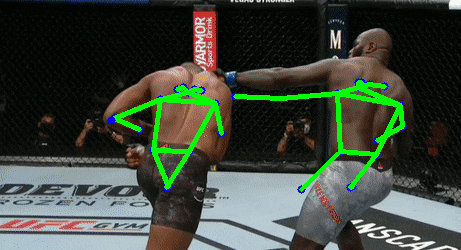

In [17]:
output = np.stack(output_frames, axis=0)
imageio.mimsave("./animation.gif",output, fps=10)
embed.embed_file('./animation.gif')

# Thank you for your time ! :-)

Acknowledgements : 
- TF tutorials 

Ibrahim SEROUIS, 2022